In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix,f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import re
import nltk
from wordcloud import WordCloud

In [3]:
df=pd.read_csv('english_dataset.tsv',sep='\t')

In [4]:
df.head(15)

,text_id,text,task_1,task_2,task_3
0,hasoc_en_1,#DhoniKeepsTheGlove | WATCH: Sports Minister K...,NOT,NONE,NONE
1,hasoc_en_2,@politico No. We should remember very clearly ...,HOF,HATE,TIN
2,hasoc_en_3,@cricketworldcup Guess who would be the winner...,NOT,NONE,NONE
3,hasoc_en_4,Corbyn is too politically intellectual for #Bo...,NOT,NONE,NONE
4,hasoc_en_5,All the best to #TeamIndia for another swimmin...,NOT,NONE,NONE
5,hasoc_en_6,@kellymiller513 @TheRealOJ32 I hope you rememb...,NOT,NONE,NONE
6,hasoc_en_7,@ICC Latest design of #WC2019 trophy. #CWC2019...,NOT,NONE,NONE
7,hasoc_en_8,#ADOS #trendingnow #blacklivesmatter #justice ...,HOF,PRFN,TIN
8,hasoc_en_9,Thanks for your support! Wow 600k. Graffiti ha...,NOT,NONE,NONE
9,hasoc_en_10,By wearing the #BalidaanBadge over his gloves ...,NOT,NONE,NONE


### About the Target Variables:
**task_1:** Classiﬁcation of Hate Speech (HOF) and non-hate/offensive content.

**task_2:** If the post is HOF, task_2 is used to classify it as either hate speech (HATE), offensive content (OFFN) or profanity (PRFN).

**task_3:** It decides the target of the post, i.e., targeted insult (TIN) or untargeted (UNT).

# Preprocessing

In [5]:
df=df.drop("text_id", axis=1)

Removed the column "text_id" as it is of no significance.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5852 entries, 0 to 5851
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5852 non-null   object
 1   task_1  5852 non-null   object
 2   task_2  5852 non-null   object
 3   task_3  5852 non-null   object
dtypes: object(4)
memory usage: 183.0+ KB


#### Checking for Missing Values

In [7]:
df.isna().sum()

text      0
task_1    0
task_2    0
task_3    0
dtype: int64

There are no missing values.

In [8]:
from nltk.corpus import stopwords

In [9]:
nltk.download('stopwords')
eng_stops = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\swapn\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [10]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\swapn\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [11]:
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 

### Cleaning Tweets: Removing special characters, converting all letters to lowercase, removing stopwords and lemmatizing.

In [12]:
def process_tweet(tweets):
    # remove all the special characters
    new_tweets = re.sub("[^a-zA-Z]", " ",tweets) 
    # convert all letters to lower case
    words = tweets.lower().split()
    # remove stopwords
    words = [w for w in words if not w in eng_stops]    
    # lemmatizer 
    words = [lemmatizer.lemmatize(word) for word in words]
    # join all words back to text
    return (" ".join(words))

In [13]:
df['clean_tweets']=df['text'].apply(lambda x: process_tweet(x))

In [14]:
df.head(10)

,text,task_1,task_2,task_3,clean_tweets
0,#DhoniKeepsTheGlove | WATCH: Sports Minister K...,NOT,NONE,NONE,#dhonikeepstheglove | watch: sport minister ki...
1,@politico No. We should remember very clearly ...,HOF,HATE,TIN,@politico no. remember clearly #individual1 ad...
2,@cricketworldcup Guess who would be the winner...,NOT,NONE,NONE,@cricketworldcup guess would winner #cwc19? te...
3,Corbyn is too politically intellectual for #Bo...,NOT,NONE,NONE,corbyn politically intellectual #borisjohnsons...
4,All the best to #TeamIndia for another swimmin...,NOT,NONE,NONE,best #teamindia another swimming competition s...
5,@kellymiller513 @TheRealOJ32 I hope you rememb...,NOT,NONE,NONE,@kellymiller513 @therealoj32 hope remembered w...
6,@ICC Latest design of #WC2019 trophy. #CWC2019...,NOT,NONE,NONE,@icc latest design #wc2019 trophy. #cwc2019 #c...
7,#ADOS #trendingnow #blacklivesmatter #justice ...,HOF,PRFN,TIN,#ados #trendingnow #blacklivesmatter #justice ...
8,Thanks for your support! Wow 600k. Graffiti ha...,NOT,NONE,NONE,thanks support! wow 600k. graffiti massive imp...
9,By wearing the #BalidaanBadge over his gloves ...,NOT,NONE,NONE,wearing #balidaanbadge glove @msdhoni shown lo...


# Exploratory Data Analysis

C:\Users\swapn\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


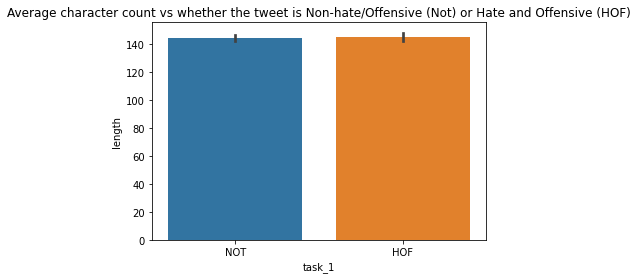

In [15]:
df['length'] =  df['clean_tweets'].apply(len)
fig1 = sns.barplot('task_1', 'length', data= df)
plt.title('Average character count vs whether the tweet is Non-hate/Offensive (Not) or Hate and Offensive (HOF)')
plt.show()

Hence, there is no relation between the character count and type of tweet.

### Checking the distribution of samples (i.e, checking for class imbalance)

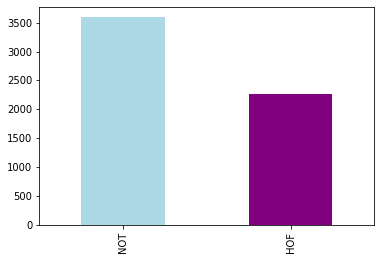

In [16]:
df.task_1.value_counts().plot(kind="bar", color=[ "lightblue", "purple"]);

Clearly, we have an **unbalanced target column.**

This needs to be taken into consideration while training the model.

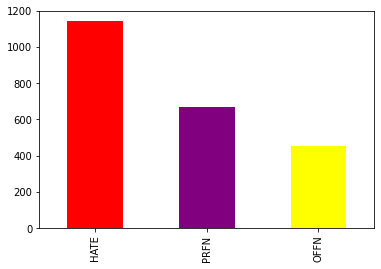

In [17]:
df_hof = df[df["task_1"]=="HOF"]

df_hof.task_2.value_counts().plot(kind="bar", color=[ "red", "purple", "yellow"]);

Majority of the HOF tweets are **hate** tweets followed by tweets containing profanity and offensive content. 

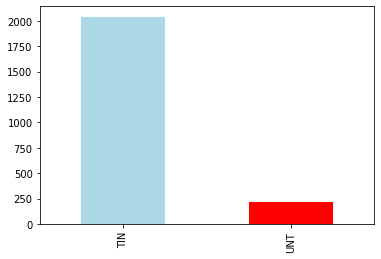

In [18]:
df_hof.task_3.value_counts().plot(kind="bar", color=["lightblue", "red", "lightgreen"]);

Most of the hate and offensive tweets are **targeted insults** and only about 12.5% are untargeted.

In [19]:
hof_tweets= df_hof.clean_tweets
hof_words = ' '.join(hof_tweets)

### Plotting the wordcloud for the words that appear the most in hate and offensive tweets

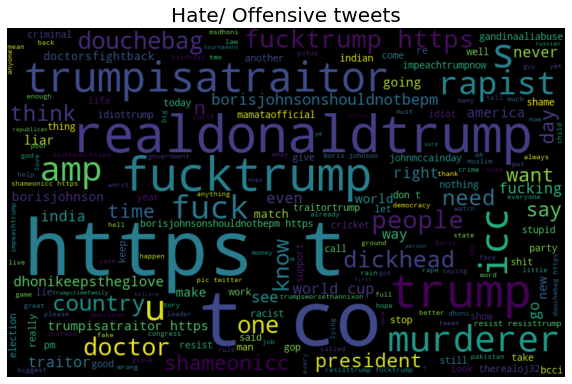

In [131]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(hof_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Frequently used words in Hate/ Offensive tweets', size=20)
plt.axis('off')
plt.show()

<AxesSubplot:>

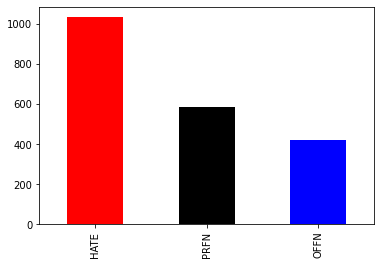

In [20]:
df_tin=df[df["task_3"]=="TIN"]
df_tin.task_2.value_counts().plot(kind="bar",color=["red","black","blue"])

### This Plot shows the Hate Profanity against Targeted Units.

<AxesSubplot:>

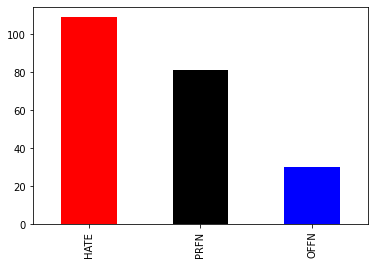

In [21]:
df_unt=df[df["task_3"]=="UNT"]
df_unt.task_2.value_counts().plot(kind="bar",color=["red","black","blue"])

### This Plot shows the Hate Profanity and Offensive tweets against Untargeted units.

It is evident that Profanity to Hate ratio against untargeted units is greater than that of targeted units.